In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
import numpy as np

In [6]:
IMAGE_SIZE = 256
BATCH_SIZE = 16

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "datasets",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5000 files belonging to 5 classes.


In [8]:
classes = dataset.class_names
classes

['Tomato___Early_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___healthy']

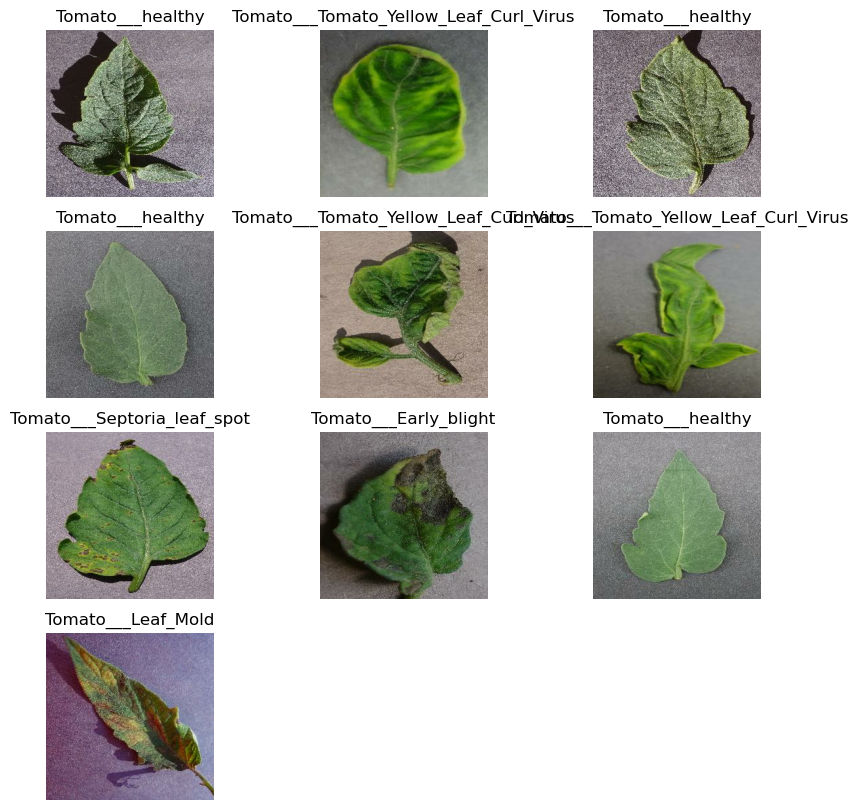

In [9]:
plt.figure(figsize=(10,10))
for image_batch, lable_batch in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis("off")
        plt.title(classes[lable_batch[i]])

In [10]:
len(dataset)

313

In [11]:
def get_partition(ds, train_size=0.8, valid_size=0.1, test_size=0.1, shuffle=True, shuffle_size=1000):
    total_size=len(ds)
    if(shuffle):
        ds=ds.shuffle(shuffle_size, seed=12)
    
    train_split = int(train_size*total_size)
    valid = int(valid_size*total_size)
    test_split = int(test_size*total_size)
    
    train = ds.take(train_split)
    validation = ds.skip(train_split).take(valid)
    test = ds.skip(train_split).skip(valid)
    
    return train, validation, test

In [12]:
train_ds, valid_ds, test_ds = get_partition(dataset)

In [13]:
train_ds = train_ds.cache().shuffle(1000)
val_ds = valid_ds.cache().shuffle(1000)
test_ds = test_ds.cache().shuffle(1000)

In [14]:
reshape = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256, 256),
    layers.experimental.preprocessing.Rescaling(1.0/255.0)
])

In [15]:
argumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [16]:
model = models.Sequential([
    reshape,
    argumentation,
    layers.Conv2D(16, (3,3), input_shape=(256,256,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')
])
model.build(input_shape=(BATCH_SIZE, 256, 256, 3))

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (16, 127, 127, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (16, 62, 62, 32)          0         
 g2D)                                                 

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
model.fit(
    train_ds,
    epochs=10,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
250/250 [==============================] - 268s 941ms/step - loss: 1.2898 - accuracy: 0.4366 - val_loss: 0.7997 - val_accuracy: 0.6875
Epoch 2/10
250/250 [==============================] - 217s 870ms/step - loss: 0.7046 - accuracy: 0.7380 - val_loss: 0.7022 - val_accuracy: 0.7641
Epoch 3/10
250/250 [==============================] - 370s 1s/step - loss: 0.4993 - accuracy: 0.8081 - val_loss: 0.5820 - val_accuracy: 0.7802
Epoch 4/10
250/250 [==============================] - 202s 807ms/step - loss: 0.3789 - accuracy: 0.8565 - val_loss: 1.1047 - val_accuracy: 0.7036
Epoch 5/10
250/250 [==============================] - 218s 871ms/step - loss: 0.3443 - accuracy: 0.8747 - val_loss: 0.5611 - val_accuracy: 0.8226
Epoch 6/10
250/250 [==============================] - 218s 870ms/step - loss: 0.2951 - accuracy: 0.8908 - val_loss: 0.4075 - val_accuracy: 0.8528
Epoch 7/10
250/250 [==============================] - 221s 883ms/step - loss: 0.2659 - accuracy: 0.8990 - val_loss: 0.4032 - va

In [20]:
model.evaluate(test_ds)

32/32 [==============================] - 42s 194ms/step - loss: 0.3926 - accuracy: 0.8535


[0.39256227016448975, 0.853515625]

In [21]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(image_batch[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    predicted = model.predict(img_array)
    conf = round(100*(np.max(predicted)),2)
    pred_val = classes[np.argmax(predicted)]
    return pred_val,conf

1/1 [==============================] - 0s 74ms/step


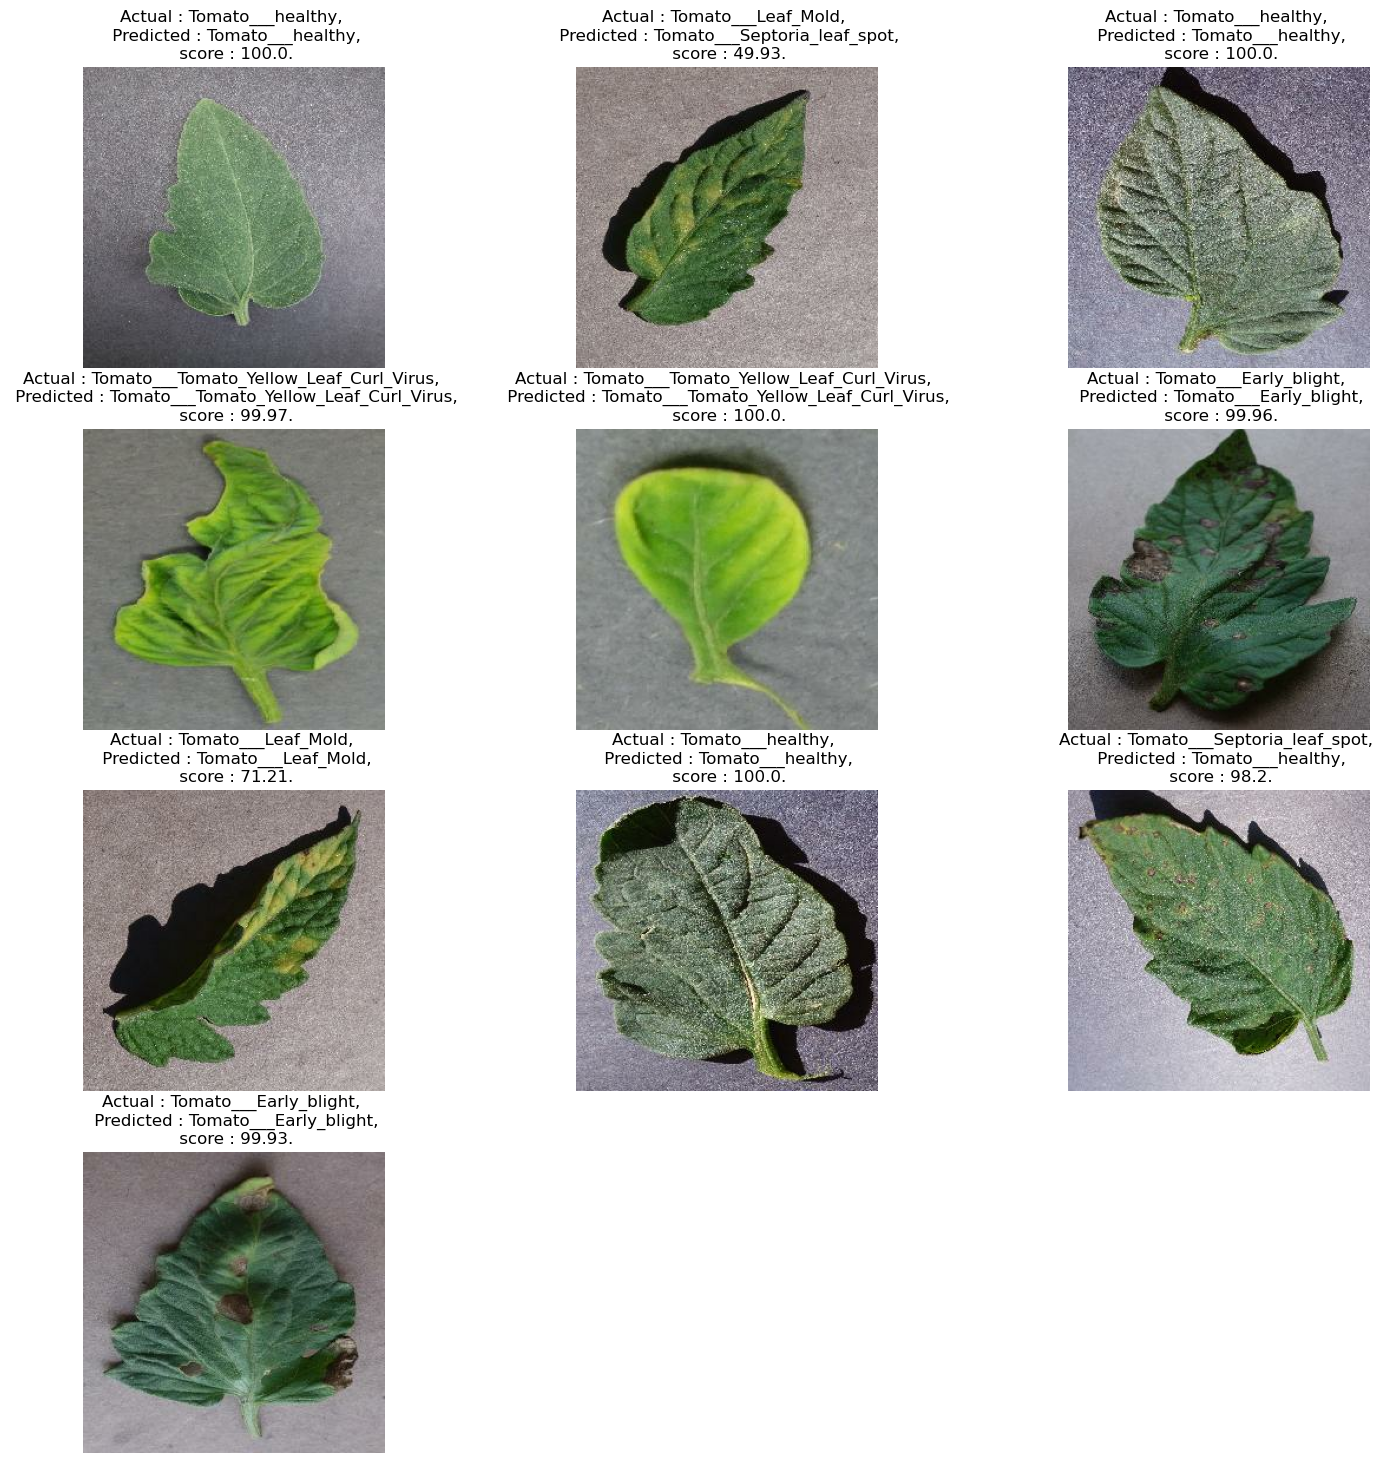

In [24]:
plt.figure(figsize=(18,18))
for image_batch, lable_batch in test_ds.take(1):
    for i in range(10):
        pred,confi = predict(model,image_batch.numpy())
        ax = plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis("off")
        actual = classes[lable_batch[i]]
        plt.title(f"Actual : {actual}, \n Predicted : {pred},\n score : {confi}.")

In [36]:
pred_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "prediction",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 8 files belonging to 5 classes.


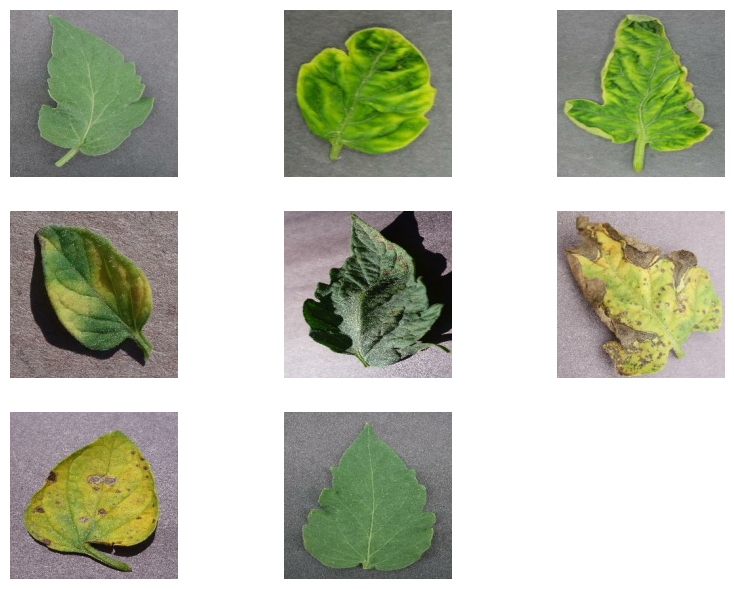

In [37]:
plt.figure(figsize=(10,10))
for image_batch, lable_batch in pred_ds.take(1):
    for i in range(8):
        ax = plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis("off")
        

In [38]:
pred_classes = pred_ds.class_names
pred_classes

['Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Early_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___healthy']

1/1 [==============================] - 0s 79ms/step


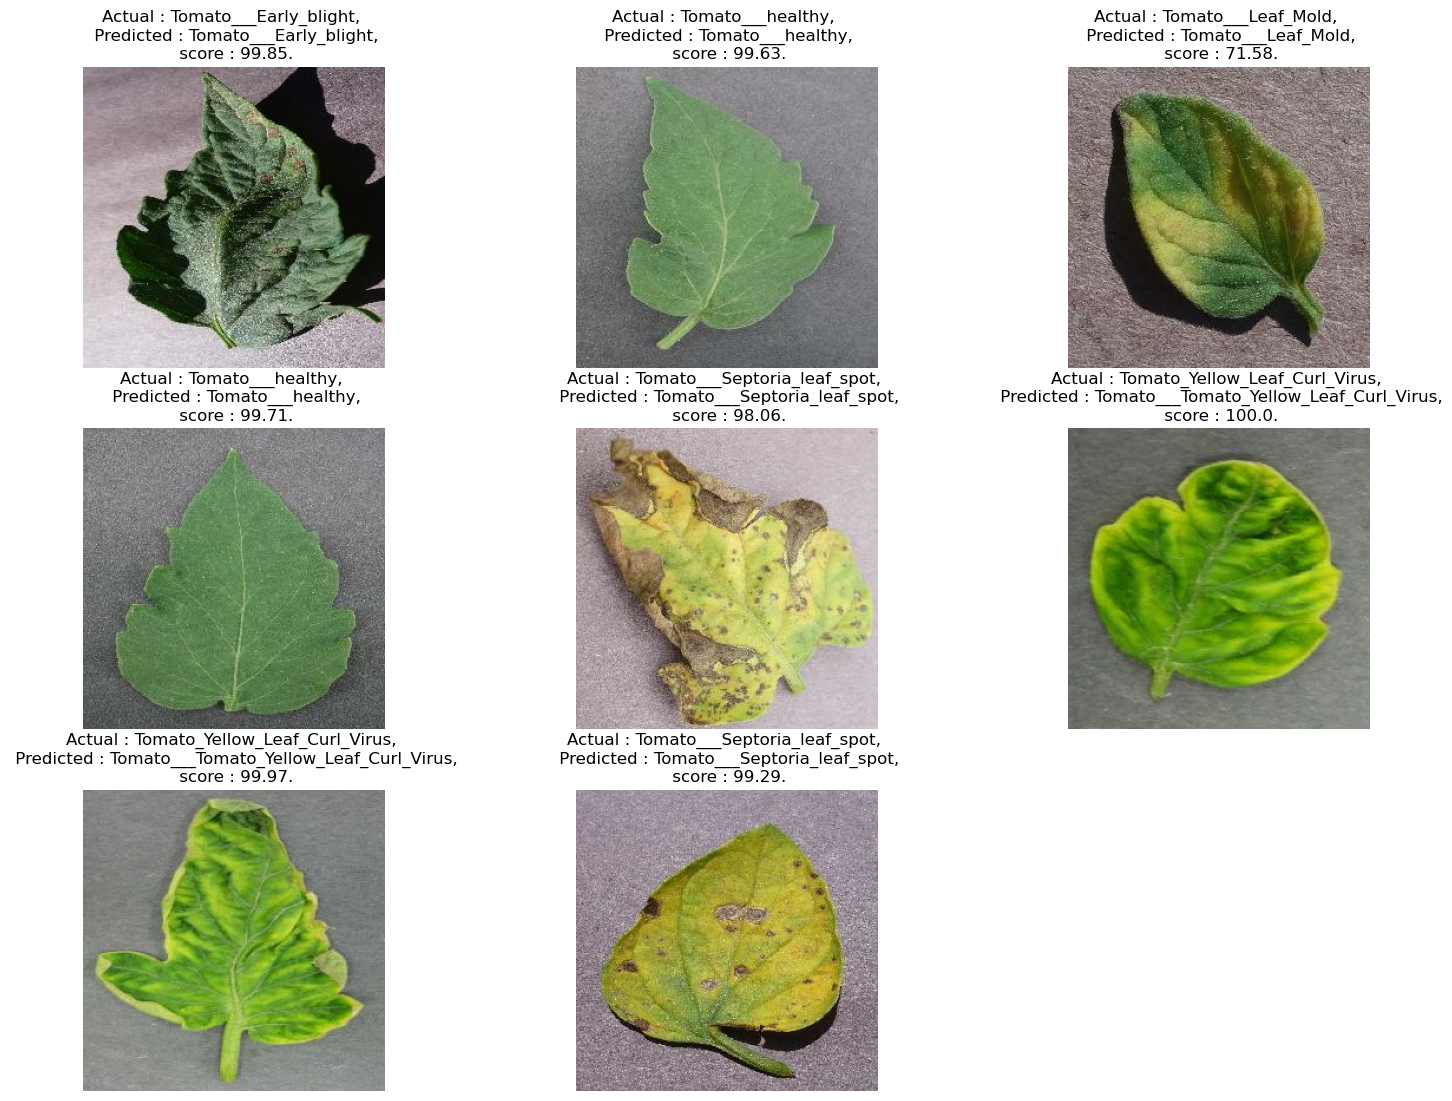

In [39]:
plt.figure(figsize=(18,18))
for image_batch, lable_batch in pred_ds.take(1):
    for i in range(8):
        pred,confi = predict(model,image_batch.numpy())
        ax = plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis("off")
        actual = pred_classes[lable_batch[i]]
        plt.title(f"Actual : {actual}, \n Predicted : {pred},\n score : {confi}.")